# Logistic Regression
Logistic Regression uses a link function to confine outcome estimates within the range of 0 and 1. Its interpretability has elevated its status, particularly in highly regulated industries. Additionally, Logistic Regression showcases flexibility by accommodating interactions, polynomial terms, and transformations to model complex relationships. The provided code covers essential aspects of Logistic Regression using sklearn:
- Fitting a Logistic Regression model
- Analyzing basic fit statistics.
- Fine-tuning optimization parameters (solver, max iteration)
- Incorporating polynomial and interaction effects
- Conducting feature selection


In [1]:
# Pre-Process
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
bat = pd.read_csv('../../06 - Utility & References/Data/player_batting_enriched.csv', index_col='player_id')

In [2]:
# Data pre-process
train = bat[bat['year']==2021]
test = bat[bat['year']==2022]
y_train = train['hr_10'].copy()
X_train = train[['ab','exit_velocity_avg', 'batting_avg','r_total_stolen_base']].copy()
X_train['exit_velocity_avg'] = X_train['exit_velocity_avg'].fillna(X_train['exit_velocity_avg'].median())
y_test = test['hr_10'].copy()
X_test = test[['ab','exit_velocity_avg', 'batting_avg','r_total_stolen_base']].copy()
X_test['exit_velocity_avg'] = X_test['exit_velocity_avg'].fillna(X_test['exit_velocity_avg'].median())

In [3]:
# Fit a logistic regression model to the training data
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [4]:
# Predictions follow the outcome data type (boolean)
pred_test = model1.predict(X_test)
pred_test[:10]

array([ True,  True, False, False, False,  True,  True, False, False,
        True])

In [5]:
# Simple Accuracy and Misclassification
accuracy = accuracy_score(y_test, pred_test)
missclass = 1-accuracy 
print('Accuracy:', round(accuracy,4))
print('Missclassification:', round(missclass,4))

Accuracy: 0.8773
Missclassification: 0.1227


In [6]:
# quick function to find accuracy for the next models:
def accuracy_missc(model):
    pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_test)
    missclass = 1-accuracy 
    print('Accuracy:', round(accuracy,4))
    print('Missclassification:', round(missclass,4))

In [7]:
# The algorithm to find the parameters can be choose using the solver parameter
# - 'newton-cg': Newton-Conjugate Gradient
# - 'lbfgs': Limited-memory Broyden–Fletcher–Goldfarb–Shanno (Default for the version I used to create this code)
# - 'liblinear': Library for Large Linear Classification
# - 'sag': Stochastic Average Gradient Descent
# - 'saga': SAGA (Stochastic Average Gradient Descent for Logistic Regression)
model2 = LogisticRegression(solver='sag')
model2.fit(X_train, y_train)
accuracy_missc(model2)

Accuracy: 0.8494
Missclassification: 0.1506


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
# max_iter controls how many iterations the solver have
model3 = LogisticRegression(solver='sag',max_iter = 1000)
model3.fit(X_train, y_train)
accuracy_missc(model3)
# For this specific case the not converged model performed better, that means some overfitting is going on

Accuracy: 0.8463
Missclassification: 0.1537


In [9]:
# If you want to reproduce the same results is a good idea to fix the random seed:
model4 = LogisticRegression(random_state = 42)
model4.fit(X_train, y_train)
accuracy_missc(model4)

Accuracy: 0.8773
Missclassification: 0.1227


In [10]:
# To add polynomial features we can use PolynomialFeatures(). Pipeline can help streamline the steps at once
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
model5 = make_pipeline(PolynomialFeatures(2, include_bias=True), LogisticRegression(max_iter=1000))
model5.fit(X_train, y_train)
accuracy_missc(model5)

Accuracy: 0.8804
Missclassification: 0.1196


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# By default, PolynomialFeatures() includes both the squared terms and interaction terms. If you want to exclude quared terms you can use:
model6 = make_pipeline(PolynomialFeatures(2, interaction_only=True, include_bias=True), LogisticRegression(max_iter=1000))
model6.fit(X_train, y_train)
accuracy_missc(model6)

Accuracy: 0.882
Missclassification: 0.118


In [12]:
# Feature Selection: RFE (Recursive Feature Elimination)
from sklearn.feature_selection import RFE
model_select = LogisticRegression(max_iter=1000)
model7 = make_pipeline(RFE(model_select, n_features_to_select=3), LogisticRegression(max_iter=1000))
model7.fit(X_train, y_train)
accuracy_missc(model7)

Accuracy: 0.7609
Missclassification: 0.2391


In [13]:
 # Feature Selection: L1 penalty also can help
model8 = LogisticRegression(penalty='l1', solver='saga', max_iter=1000) # changing solver because of l1 (convex vs non convex)
model8.fit(X_train, y_train)
accuracy_missc(model8)
model8.coef_ # Third coef=0

Accuracy: 0.8463
Missclassification: 0.1537


array([[ 0.01517403, -0.05345859,  0.        , -0.05839193]])

In [14]:
# Bonus: This function can help with simple fit statistics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

def accuracy_report(model,values_list):
    '''This function will assess model performance. Given a sklearn model it will Predict, and measure performance for both Test and Train Data'''
    #Train
    print('Train Data:\n-----------')
    pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, pred_train)
    print('Accuracy:', round(accuracy_train,4))
    print(classification_report(y_train, pred_train))
    roc_plot(model,X_train,y_train,values_list)
    #Test
    print('Test Data:\n----------')
    pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, pred_test)
    print('Accuracy:', round(accuracy_test,4))
    print(classification_report(y_test, pred_test))
    roc_plot(model,X_test,y_test,values_list)
def roc_plot(model,X_data,y_data,values_list):
    y_scores = model.predict_proba(X_data)[:, 1]
    y_data = y_data.map({values_list[0]:0,values_list[1]:1})
    fpr, tpr, thresholds = roc_curve(y_data, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(3, 2))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Train Data:
-----------
Accuracy: 0.888
              precision    recall  f1-score   support

       False       0.91      0.93      0.92       508
        True       0.84      0.79      0.81       224

    accuracy                           0.89       732
   macro avg       0.87      0.86      0.87       732
weighted avg       0.89      0.89      0.89       732



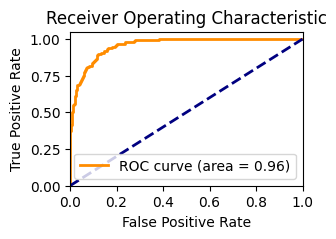

Test Data:
----------
Accuracy: 0.8773
              precision    recall  f1-score   support

       False       0.93      0.88      0.91       440
        True       0.78      0.86      0.82       204

    accuracy                           0.88       644
   macro avg       0.85      0.87      0.86       644
weighted avg       0.88      0.88      0.88       644



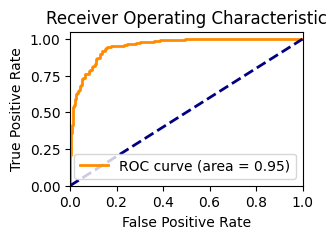

In [15]:
# Calling the function
accuracy_report(model1,[False,True])

Check [here](https://github.com/danielrferreira/pySETTV/tree/main/05%20-%20Validate/Model%20Comparison) for more information on Model Assessment or Comparison.